<a href="https://colab.research.google.com/github/vaswin0/tbClassification/blob/main/gradCamMasked.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import numpy as np

from keras import layers
from keras.models import Model
import keras

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

from keras import layers, models


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [ ]:
bb = np.load('/content/drive/MyDrive/tbData/b_phipt.npy').reshape((-1, 64, 64, 1))
tt = np.load('/content/drive/MyDrive/tbData/t_phipt.npy').reshape((-1, 64, 64, 1))

In [ ]:
XX = np.append(bb, tt, axis=0)
Y = np.append(np.ones(len(bb)), np.zeros(len(tt))).reshape((-1, 1))


In [ ]:
X = np.copy(XX)
X[:, :, 32:, :] = 0  # mask last 32 columns (right half in φ)
#X is masked

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

In [ ]:


# Load your model (if you haven't already)
model = tf.keras.models.load_model('/content/drive/MyDrive/tbData/tip_body_MaskedModel.h5')

# Get the last conv layer name
model.summary()
last_conv_layer_name = [layer.name for layer in model.layers if 'conv' in layer.name][-1]
print("Using last conv layer:", last_conv_layer_name)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 15, 15, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 15, 15, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 2, 2, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,198,980 (8.39 MB)

 Trainable params: 2,198,978 (8.39 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

Using last conv layer: conv2d_4


In [ ]:
# Grad-CAM function
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_output = predictions[:, pred_index]

    grads = tape.gradient(class_output, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


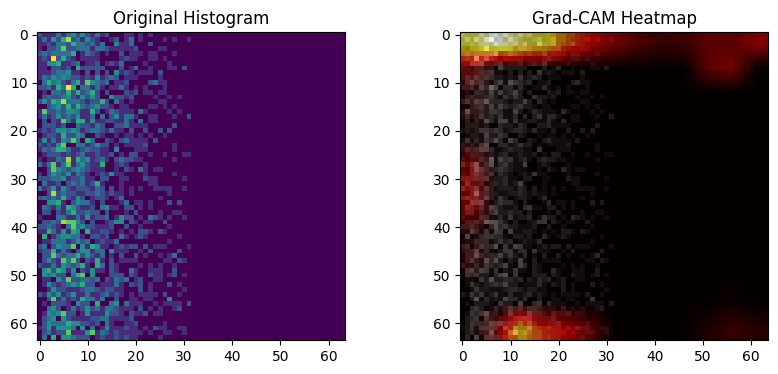

In [ ]:
# Pick a test sample (index 0 here, can change)
k = 1
img = X_test[k]
img_input = np.expand_dims(img, axis=0)

# Generate heatmap
heatmap = make_gradcam_heatmap(img_input, model, last_conv_layer_name='conv2d_3')

# Plot original + Grad-CAM overlay
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title("Original Histogram")
plt.imshow(img.squeeze(), cmap='viridis')

plt.subplot(1, 2, 2)
plt.title("Grad-CAM Heatmap")
plt.imshow(img.squeeze(), cmap='gray')
plt.imshow(cv2.resize(heatmap, (64, 64)), cmap='hot', alpha=0.6)
plt.show()


In [ ]:
true_class = np.argmax(Y_test[k])
print("True class:", true_class)

pred_class = np.argmax(model.predict(np.expand_dims(X_test[k], axis=0)))
print("Predicted class:", pred_class)



True class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Predicted class: 0


In [ ]:
# Separate out tip-tip and body-body examples from test set
tip_indices = np.where(np.argmax(Y_test, axis=1) == 0)[0]
body_indices = np.where(np.argmax(Y_test, axis=1) == 1)[0]

# Pick 100 samples from each class
tip_sample_indices = tip_indices[:200]
body_sample_indices = body_indices[:200]

# Initialize accumulators
tip_heatmaps = []
body_heatmaps = []


In [ ]:
# Generate Grad-CAMs for each class
for i in tip_sample_indices:
    img = np.expand_dims(X_test[i], axis=0)
    heatmap = make_gradcam_heatmap(img, model, last_conv_layer_name='conv2d_3')
    tip_heatmaps.append(cv2.resize(heatmap, (64, 64)))

for i in body_sample_indices:
    img = np.expand_dims(X_test[i], axis=0)
    heatmap = make_gradcam_heatmap(img, model, last_conv_layer_name='conv2d_3')
    body_heatmaps.append(cv2.resize(heatmap, (64, 64)))

# Average heatmaps
avg_tip_heatmap = np.mean(np.stack(tip_heatmaps), axis=0)
avg_body_heatmap = np.mean(np.stack(body_heatmaps), axis=0)


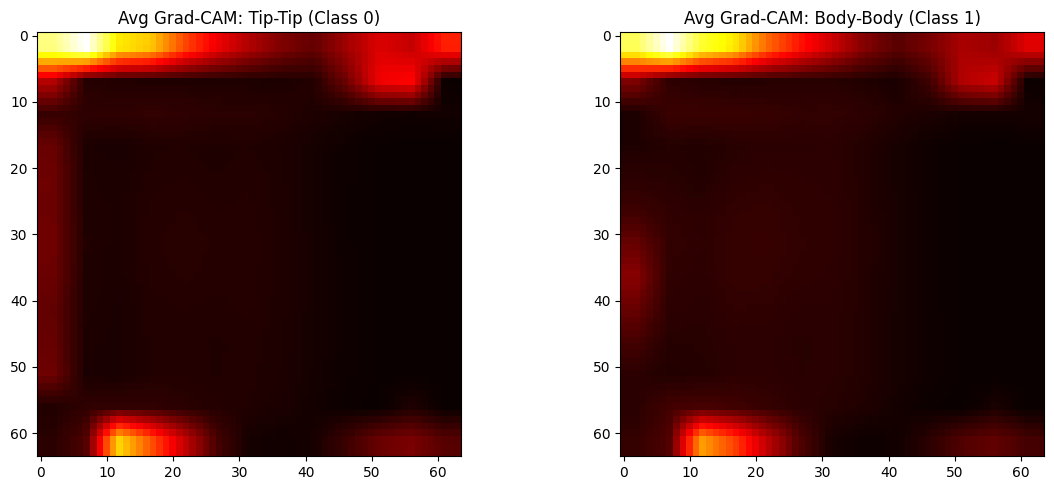

In [ ]:
# Plot the average heatmaps
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("Avg Grad-CAM: Tip-Tip (Class 0)")
plt.imshow(avg_tip_heatmap, cmap='hot', interpolation='nearest')

plt.subplot(1, 2, 2)
plt.title("Avg Grad-CAM: Body-Body (Class 1)")
plt.imshow(avg_body_heatmap, cmap='hot', interpolation='nearest')

plt.tight_layout()
plt.show()


In [ ]:
# Example: check the first few histograms
for i in range(5):
    hist = X[i].squeeze()  # shape: (64, 64)
    print(f"Histogram {i}: sum = {np.sum(hist):.2f}, max = {np.max(hist):.2f}")


Histogram 0: sum = 155.14, max = 0.57
Histogram 1: sum = 226.41, max = 0.73
Histogram 2: sum = 185.44, max = 0.73
Histogram 3: sum = 140.40, max = 0.66
Histogram 4: sum = 179.53, max = 0.62
